# Entropy Based Transformer


This notebook implements entropy-informed pre-tokenization strategies for Chinese text using BPE tokenization. The approach use predictive entropies from a pretrained GPT-2 model to detect boundary uncertainty.

The implementation evaluates these methods on a subset of the PKU corpus, comparing segmentation precision, recall and F1 scores against standard BPE tokenization.

#### Key features:
- Computes next-token entropy using transformer models
- Visualizes entropy distributions along token positions
- Supports both GPT-2 and BERT models for entropy calculation
- Includes utilities for text preprocessing and analysis

This work demonstrates how entropy-guided pre-tokenization can improve alignment with linguistic units and enhance tokenization quality for unsegmented languages like Chinese.


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BertTokenizer, GPT2LMHeadModel
import math
import matplotlib.pyplot as plt
import re
import ast
from typing import List
import os


import matplotlib.font_manager as fm

fm.fontManager.addfont("./data/SimHei.ttf")

# Set SimHei as the default font for sans-serif
plt.rcParams["font.family"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False

### Preprocessing Functions

In [7]:
def split_chinese_punct(text):
    """
    Split a Chinese text on punctuation, keeping the punctuation (and any
    immediately following space) as separate items.
    """
    # Define the set of punctuation marks to split on
    punct = '，。！？、；：'
    # Pattern: capture any of those marks, plus optionally one following space
    pattern = rf'([{punct}]\s?)'
    # Split, keeping the delimiters
    parts = re.split(pattern, text)
    # Remove any empty strings
    return [p for p in parts if p]

def clean_digits(text: str) -> str:
    """
    Remove '##' from digits like '７##００##０' or '##９８' in the text.
    This function preserves the digits while removing the '##' markers.
    
    Args:
        text: Input text containing digits with '##' markers
        
    Returns:
        Cleaned text with '##' removed from digits
    """
    # Regular expression to match digits with '##' between them
    # This pattern looks for digit sequences that may contain '##'
    pattern = r'([０-９0-9]+)(##)([０-９0-9]+)'
    
    # Keep replacing until no more matches are found
    while re.search(pattern, text):
        text = re.sub(pattern, r'\1\3', text)
    
    # Also handle cases where '##' appears at the beginning of a digit
    pattern_prefix = r'(##)([０-９0-9]+)'
    while re.search(pattern_prefix, text):
        text = re.sub(pattern_prefix, r'\2', text)
    
    # Also handle cases where '##' appears at the end of a digit
    pattern_suffix = r'([０-９0-9]+)(##)'
    while re.search(pattern_suffix, text):
        text = re.sub(pattern_suffix, r'\1', text)
    
    return text

### Entropy Calculation Functions & Plotting Functions

In [8]:
def compute_next_token_entropy(context_ids, model):
    """
    Given a tensor of token IDs as context, compute the entropy (in bits)
    of the model's next-token probability distribution.
    """
    with torch.no_grad():
        outputs = model(context_ids)
    # Extract logits for the next token (last token in sequence)
    logits = outputs.logits[0, -1, :]
    probs = torch.softmax(logits, dim=-1)
    entropy = -torch.sum(probs * torch.log2(probs + 1e-12)).item()
    return entropy

def compute_entropy_along_text(text, tokenizer, model, add_special_tokens=True):
    """
    Tokenize the input text (with or without special tokens) and compute
    the next-token entropy for each prefix of the tokenized sequence.
    
    Returns:
        input_ids (list[int]): The list of token IDs.
        entropies (list[float]): The next-token entropy values (in bits) computed
                                 at each token position (based on preceding context).
    """
    input_ids = tokenizer.encode(text, add_special_tokens=add_special_tokens)
    entropies = []
    # We start from 1 because an empty context is invalid; thus context [0:i] for i>=1.
    for i in range(1, len(input_ids) + 1):
        context_ids = torch.tensor([input_ids[:i]])
        entropy = compute_next_token_entropy(context_ids, model)
        entropies.append(entropy)
    return input_ids, entropies

def detect_entropy_peaks(entropies, min_peak_diff=0.0):
    """
    Detect local peaks in the entropy curve.
    A token position i is considered a peak if:
        entropy[i] > entropy[i-1] and entropy[i] > entropy[i+1]
    and (optionally) the differences with the neighbors are at least min_peak_diff.

    Additionally, we ensure the first and last positions are always included as boundaries.
    
    Returns:
        List[int]: The indices (in the entropy list) of detected peaks.
    """
    peaks = []
    n = len(entropies)
    # Handle single-element case:
    if n == 0:
        return peaks

    # Always include the first position.
    peaks.append(0)
    # Check intermediate indices
    for i in range(1, n - 1):
        if entropies[i] > entropies[i - 1] and entropies[i] > entropies[i + 1]:
            # Optionally require a minimal difference (min_peak_diff)
            if ((entropies[i] - entropies[i - 1] >= min_peak_diff) and 
                (entropies[i] - entropies[i + 1] >= min_peak_diff)):
                peaks.append(i)
        elif entropies[i] <= entropies[i - 1] and entropies[i] > entropies[i + 1]:
            if (entropies[i - 1] - entropies[i]) * 7 <=  (entropies[i] - entropies[i + 1]):
                peaks.append(i)
    # Always include the last position.
    peaks.append(n - 1)
    return peaks



def split_text_by_entropy(raw_text, tokenizer, model, add_special_tokens=True, min_peak_diff=0.0):
    """
    Compute the entropy for each token position using the next-token entropy,
    detect local entropy peaks (as potential word boundaries), and then
    split the token sequence into segments based on these boundaries.

    Returns:
        tokens (list[str]): The decoded tokens corresponding to the input.
        entropies (list[float]): The computed next-token entropy values.
        peak_indices (list[int]): The indices (in the token list) identified as local peaks.
        segments (list[str]): The text segments, constructed by joining tokens between boundaries.
    """
    token_ids, entropies = compute_entropy_along_text(raw_text, tokenizer, model, add_special_tokens)
    tokens = [tokenizer.decode([tid]) for tid in token_ids]
    
    # Detect local peaks in the entropy curve
    peak_indices = detect_entropy_peaks(entropies, min_peak_diff)
    
    # Use detected peak indices to split the token list.
    segments = []
    # We'll build segments by slicing the tokens list between boundaries
    special_tokens = {tokenizer.cls_token, tokenizer.sep_token}
    
    start = 0
    # Iterate over each detected boundary after the first one.
    for peak in peak_indices[1:]:
        # Slice tokens from start up to the current peak (inclusive)
        segment_tokens = tokens[start:peak+1]
        # Filter out special tokens from this segment
        filtered_tokens = [t for t in segment_tokens if t not in special_tokens]
        segment = "".join(filtered_tokens)
        seg_punc = split_chinese_punct(segment)
        segments.extend(seg_punc)
        start = peak + 1
    # If any tokens remain after the last boundary, add them (after filtering)
    if start < len(tokens):
        filtered_tokens = [t for t in tokens[start:] if t not in special_tokens]
        
        segments.extend(split_chinese_punct("".join(filtered_tokens)))

        
    return tokens, entropies, peak_indices, segments

def analyze_plot_and_split(raw_text, tokenizer, model, add_special_tokens=True, min_peak_diff=0.0):
    """
    Calculate the next-token entropy along the input text, detect local peaks,
    plot the entropy curve (with peaks marked), and return the tokens, entropy values,
    detected peak indices, and the resulting text segments.
    """
    token_ids, entropies = compute_entropy_along_text(raw_text, tokenizer, model, add_special_tokens)
    tokens = [tokenizer.decode([tid]) for tid in token_ids]
    peak_indices = detect_entropy_peaks(entropies, min_peak_diff)
    _, _, _, segments = split_text_by_entropy(raw_text, tokenizer, model, add_special_tokens, min_peak_diff)

    # Plot the entropy curve and mark the peaks.
    plt.figure(figsize=(10, 5))
    x_positions = list(range(1, len(entropies) + 1))
    plt.plot(x_positions, entropies, marker='o', linestyle='-', label='Entropy')
    # Mark peaks with red dots
    peak_x = [x_positions[i] for i in peak_indices]
    peak_y = [entropies[i] for i in peak_indices]
    plt.scatter(peak_x, peak_y, color='red', zorder=5, label='Peaks')
    
    plt.title("Next-Token Entropy (Local Peaks as Boundaries)")
    plt.xlabel("Token Position")
    plt.ylabel("Entropy (bits)")
    plt.xticks(x_positions, tokens, rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    return tokens, entropies, peak_indices, segments

def plot_entropy(token_ids, entropies, tokenizer):
    """
    Plot the entropy values along token positions.
    
    Args:
        token_ids (list[int]): The list of token IDs for the input text.
        entropies (list[float]): Entropy values computed for each token position.
        tokenizer: The tokenizer to decode the tokens.
    """
    # Decode token IDs to token strings
    tokens = [tokenizer.decode([tid]) for tid in token_ids]
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(entropies)), entropies[:-1], marker='o', linestyle='-')
    plt.title("Entropy at Current Token Position Given Prev Context")
    plt.xlabel("Token Position")
    plt.ylabel("Entropy (bits)")
    plt.xticks(range(0, len(tokens)), tokens)
    plt.tight_layout()
    plt.show()

### Result Processing Functions

process the entropy file and output files to consistent format


In [10]:
def process_entropy_file(
    input_path: str,
    output_path: str,
    min_peak_diff: float = 0.0
) -> None:
    """
    Read each line as a list of (token_id, token, entropy) tuples,
    detect entropy peaks, build segments, and write the joined segments
    to `output_path`, one line per input.
    """
    special_tokens = {'[CLS]', '[SEP]'}
    with open(input_path, 'r', encoding='utf-8') as fin, \
         open(output_path, 'w', encoding='utf-8') as fout:
        
        for line in fin:
            line = line.strip()
            if not line:
                fout.write("\n")
                continue

            # parse the list of tuples
            data = ast.literal_eval(line)
            tokens     = [tok for _, tok, _ in data]
            entropies  = [ent for _, _, ent in data]

            # detect peaks
            peaks = detect_entropy_peaks(entropies, min_peak_diff)

            # split into segments
            segments = []
            start = 0
            for peak in peaks[1:]:
                seg_tokens = tokens[start:peak]
                filtered   = [t for t in seg_tokens if t not in special_tokens]
                segment    = "".join(filtered)
                segments.append(segment)
                start = peak
            # remaining
            if start < len(tokens):
                filtered = [t for t in tokens[start:] if t not in special_tokens]
                segments.append("".join(filtered))

            # write joined segments
            fout.write(" ".join(segments) + "\n")
            
def process_output_file(input_path: str, output_path: str) -> None:
    """
    Process the output file to clean digits with '##' markers.
    
    Args:
        input_path: Path to the input file
        output_path: Path to save the cleaned output
    """
    try:
        # Read the input file
        with open(input_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Clean the digits
        cleaned_content = clean_digits(content)
        
        # Write the cleaned content to the output file
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(cleaned_content)
            
        print(f"Successfully processed file. Cleaned content saved to {output_path}")
    except Exception as e:
        print(f"Error processing file: {e}")

def separate_chinese_punct_and_stepwords(
    input_path: str,
    output_path: str
) -> None:
    """
    Read `input_path` line by line, and for each line insert exactly one space
    before and after any Chinese punctuation or any of the specified stopword
    characters. Writes the transformed lines to `output_path`.
    """
    # Define Chinese punctuation characters
    chinese_punct = "，。！？、；：…“”‘’（）【】《》—"
    # Define the stopword characters (stepwords)
    # we do not use stepwords separate here in our experiments
    stepwords = ""
    stop_chars = "".join(stepwords.split()) 
    
    # Build a regex that matches any punctuation or any stopword char, or [UNK]
    pattern = re.compile(
        rf'(\[UNK\]|[{re.escape(chinese_punct)}{re.escape(stop_chars)}])'
    )
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(input_path,  'r', encoding='utf-8') as fin, \
         open(output_path, 'w', encoding='utf-8') as fout:
        for line in fin:
            line = line.rstrip('\n')
            if not line:
                fout.write('\n')
                continue
            
            # Surround each match with spaces
            spaced = pattern.sub(r' \1 ', line)
            # Collapse multiple spaces into one and strip edges
            cleaned = re.sub(r'\s+', ' ', spaced).strip()
            fout.write(cleaned + '\n')



In [11]:
process_entropy_file(
    input_path="entropies.txt",
    output_path="data/segments_out.txt",
    min_peak_diff=0.0
)

In [12]:
process_output_file(input_path="data/segments_out.txt", output_path="data/segments_out.txt")

Successfully processed file. Cleaned content saved to data/segments_out.txt


In [13]:
separate_chinese_punct_and_stepwords(
    input_path="data/segments_out.txt",
    output_path="data/segment_out2.txt"
)


### Entropy Model Loaded (GPT-2)

In [14]:
tokenizer1 = BertTokenizer.from_pretrained("uer/gpt2-medium-chinese-cluecorpussmall")
model1 = GPT2LMHeadModel.from_pretrained("uer/gpt2-medium-chinese-cluecorpussmall")
model1.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(21128, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=21128, bias=False)
)

#### Example

We visualize the entropy value for an example sentence "南京长江大桥在中国南京。" (Nanjing Yangtze River Bridge is located in Nanjing, China.). The entropy values help identify potential word boundaries. We identify boundaries based on local peaks in entropy, or when the previous gap is less than 1/10 of the second entropy gap.


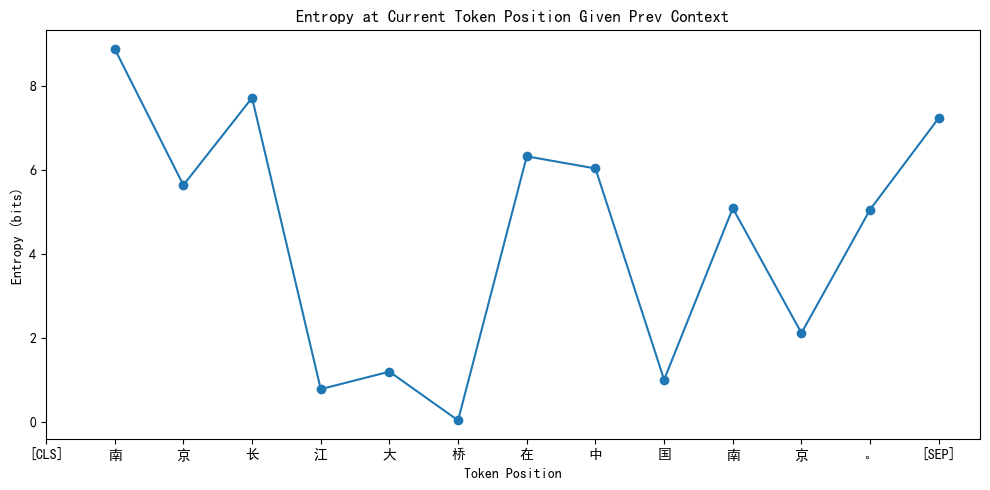

In [16]:
raw_text = "南京长江大桥在中国南京。"
token_ids, entropies = compute_entropy_along_text(raw_text, tokenizer1, model1)

plot_entropy(token_ids, entropies, tokenizer1)

#### Pre-train Entropy Calculation Script

Below is a script to calculate the entropy for input file. Then store it for later use. 
It should be only run once. Caution, it takes a really long time to finish.

```
# Determine how many lines have already been written
processed = 0
if os.path.exists("data/entropies.txt"):
    with open("data/entropies.txt", "r", encoding="utf-8") as f_exist:
        processed = sum(1 for _ in f_exist)

with open("data/no_spaces_sentences.txt", "r", encoding="utf-8") as fin, \
     open("data/entropies.txt", "a", encoding="utf-8") as fout:
    # Skip already processed lines in the input
    for _ in range(processed):
        next(fin, None)

    for line in fin:
        text = line.strip()
        if not text:
            continue
        # compute entropies including special tokens
        token_ids, entropies = compute_entropy_along_text(
            text, tokenizer1, model1, add_special_tokens=True
        )
        # drop the first and last (special) positions
        token_ids = token_ids[1:]
        entropies = entropies[:-1]
        # decode token IDs to token strings
        tokens = tokenizer1.convert_ids_to_tokens(token_ids)
        # zip into tuples (id, token, entropy)
        tuple_list = list(zip(token_ids, tokens, entropies))
        # write one list of tuples per line immediately
        fout.write(str(tuple_list) + "\n")
        fout.flush()
```

### Golden Standard Processing

1. "data/pku_training.utf8": original pku dataset before any processing

2. "data/gold_pku.txt": gold standard pku dataset after processing. Each line is a sentence now.

3. "data/raw_pku.txt": pku dataset without space. Raw sentences. Can be used as input file to entropy model

In [ ]:
def extract_test_dataset(input_file_path, output_file_path):
    """
    Extracts lines from a UTF-8 encoded file.

    Args:
        input_file_path (str): The path to the input UTF-8 file.
        output_file_path (str): The path where test lines will be saved.

    Returns:
        None
    """
    with open(input_file_path, 'r', encoding='utf-8') as infile, \
         open(output_file_path, 'w', encoding='utf-8') as outfile:

        line_count = 0
        for line in infile:
            line_count += 1
            if line_count < 1000:
                outfile.write(line)
            else:
                break
extract_test_dataset("data/pku_training.utf8", "data/pku_test.utf8")

In [ ]:
input_file = "data/pku_test.utf8"
output_file = "data/gold_pku_test.txt"

# Read the raw dataset
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

# Define a regex pattern that splits on sentence-ending punctuation.
# The pattern (?<=[。！？]) means that we split right after any one of these punctuation marks.
# You can add more punctuation (e.g., ；, …… etc.) if needed.
pattern = r'(?<=[。！？])'

# Split the text on the defined punctuation. This will keep the punctuation at the end of each sentence.
sentences = re.split(pattern, text)

# Clean the sentences by stripping whitespace and filter out any empty strings.
sentences = [s.strip() for s in sentences if s.strip()]

# Write the sentences into the output file, each sentence on a new line.
with open(output_file, "w", encoding="utf-8") as f:
    for sentence in sentences:
        f.write(sentence + "\n")

print(f"Processed {len(sentences)} sentences. Saved to file '{output_file}'.")


Processed 1818 sentences. Saved to file 'data/gold_pku_test.txt'.


In [ ]:
from pathlib import Path
INPUT_PATH = Path("data/gold_pku_test.txt")   # source file (two spaces)
OUTPUT_PATH = Path("data/gold_pku_test.txt")  # destination file (one space)

_WS_PATTERN = re.compile(r"\s+")  # collapse every run of whitespace


def normalize_line(line: str) -> str:
    """Convert all runs of whitespace into a single ASCII space."""
    # Replace full‑width spaces with ASCII for safety
    line = line.replace("\u3000", " ")
    tokens = _WS_PATTERN.split(line.strip())
    return " ".join(tokens)


def main() -> None:
    raw_lines = INPUT_PATH.read_text(encoding="utf-8").splitlines()
    with OUTPUT_PATH.open("w", encoding="utf-8") as fw:
        for raw in raw_lines:
            cleaned = normalize_line(raw)
            fw.write(cleaned + "\n")
    print(f"Written cleaned file to: {OUTPUT_PATH} (lines: {len(raw_lines)})")


if __name__ == "__main__":
    main()

Written cleaned file to: data/gold_pku_test.txt (lines: 2251)


In [ ]:
# Define file paths
input_file = "data/gold_pku_test.txt"
output_file = "data/raw_pku_test.txt"

# Open the input file for reading and output file for writing, using UTF-8 encoding.
with open(input_file, "r", encoding="utf-8") as fin, open(output_file, "w", encoding="utf-8") as fout:
    # Iterate over each line in the input file.
    for line in fin:
        # Remove all spaces (replace " " with an empty string)
        cleaned_line = line.replace(" ", "")
        # Write the cleaned line into the output file.
        fout.write(cleaned_line)

print(f"Processing complete. Cleaned data saved to '{output_file}'.")


Processing complete. Cleaned data saved to 'data/raw_pku_test.txt'.


# BERT

This is the code for BERT entropy calculation. It contains experiments that reflect BERT is not ideal for entropy calculation task to detect word boundaries. As the entropy values are highly dependent on the context, which is not suitable for our task.

In [1]:
from transformers import BertTokenizer, BertForMaskedLM

/n/home12/frankliang/miniconda/envs/blt_250324/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
def compute_masked_entropy(input_ids, mask_position, tokenizer, model):
    """
    Computes the entropy (in bits) of the masked token prediction at a given position.
    
    Args:
        input_ids (list[int]): The token ID list for the entire input.
        mask_position (int): The position in the list where we want to compute the entropy.
        tokenizer: The tokenizer (needed to get the mask token id).
        model: The BERT masked LM model.
    
    Returns:
        entropy (float): The entropy (in bits) of the prediction at the masked position.
    """
    # Make a copy so that the original input is not modified
    masked_ids = input_ids.copy()
    # Replace the token at mask_position with the mask token id
    masked_ids[mask_position] = tokenizer.mask_token_id
    # Convert to tensor (batch size = 1)
    input_tensor = torch.tensor([masked_ids])
    
    with torch.no_grad():
        outputs = model(input_tensor)
    # Extract logits at the masked position
    logits = outputs.logits[0, mask_position, :]
    # Convert logits to probability distribution
    probs = torch.softmax(logits, dim=-1)
    # Compute entropy: H = -sum(p * log2(p))
    entropy = -torch.sum(probs * torch.log2(probs + 1e-12)).item()
    return entropy

def compute_entropy_chinese_bert(text, tokenizer, model, add_special_tokens=True):
    """
    Tokenizes the input Chinese text and computes a masked-token entropy for
    each position by masking one token at a time.
    
    Args:
        text (str): Raw input text.
        tokenizer: BERT tokenizer.
        model: BERT masked language model.
        add_special_tokens (bool): Whether to have the tokenizer add [CLS] and [SEP].
        
    Returns:
        input_ids (list[int]): Encoded token IDs.
        entropies (list[float]): Entropy values (in bits) computed for each token position.
    """
    # Tokenize input text. If add_special_tokens=True, [CLS] and [SEP] are added automatically.
    input_ids = tokenizer.encode(text, add_special_tokens=add_special_tokens)
    entropies = []
    for i in range(len(input_ids)):
        entropy = compute_masked_entropy(input_ids, i, tokenizer, model)
        entropies.append(entropy)
    return input_ids, entropies

def plot_entropy(token_ids, entropies, tokenizer):
    """
    Plot the entropy values along token positions.
    
    Args:
        token_ids (list[int]): The list of token IDs for the input text.
        entropies (list[float]): Entropy values computed for each token position.
        tokenizer: The tokenizer to decode the tokens.
    """
    # Decode token IDs to token strings
    tokens = [tokenizer.decode([tid]) for tid in token_ids]
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(entropies)+1), entropies, marker='o', linestyle='-')
    plt.title("Masked Token Entropy along Token Positions")
    plt.xlabel("Token Position")
    plt.ylabel("Entropy (bits)")
    plt.xticks(range(1, len(tokens)+1), tokens)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = BertForMaskedLM.from_pretrained("bert-base-chinese")
model.eval()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

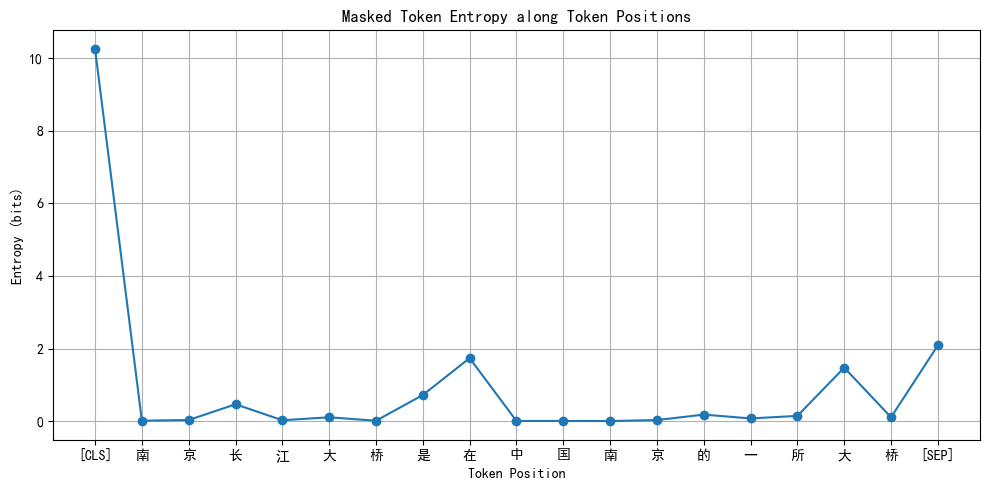

In [22]:
raw_text = "南京长江大桥是在中国南京的一所大桥"

    
# Compute per-token entropy (using a sliding masking approach)
token_ids, entropies = compute_entropy_chinese_bert(raw_text, tokenizer, model, add_special_tokens=True)
    
plot_entropy(token_ids, entropies, tokenizer)

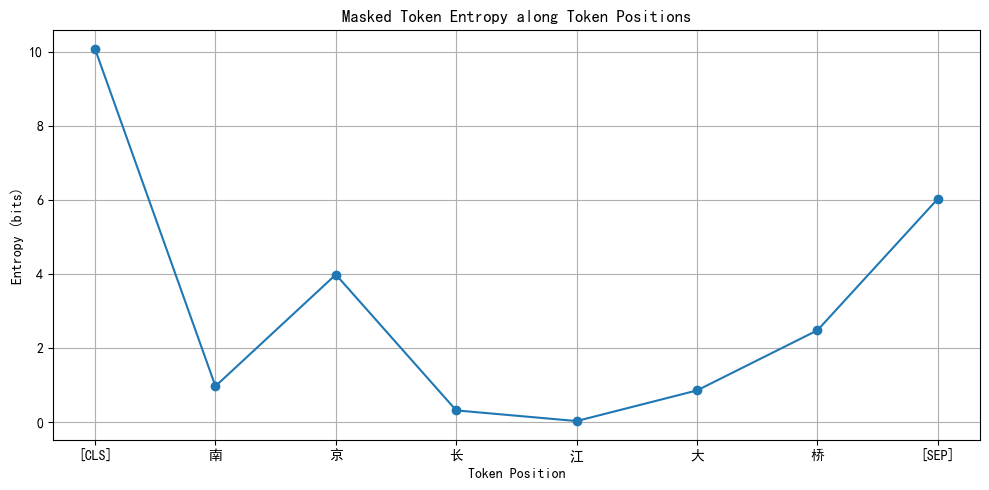

In [24]:
raw_text = "南京长江大桥"

    
# Compute per-token entropy (using a sliding masking approach)
token_ids, entropies = compute_entropy_chinese_bert(raw_text, tokenizer, model, add_special_tokens=True)
    
plot_entropy(token_ids, entropies, tokenizer)

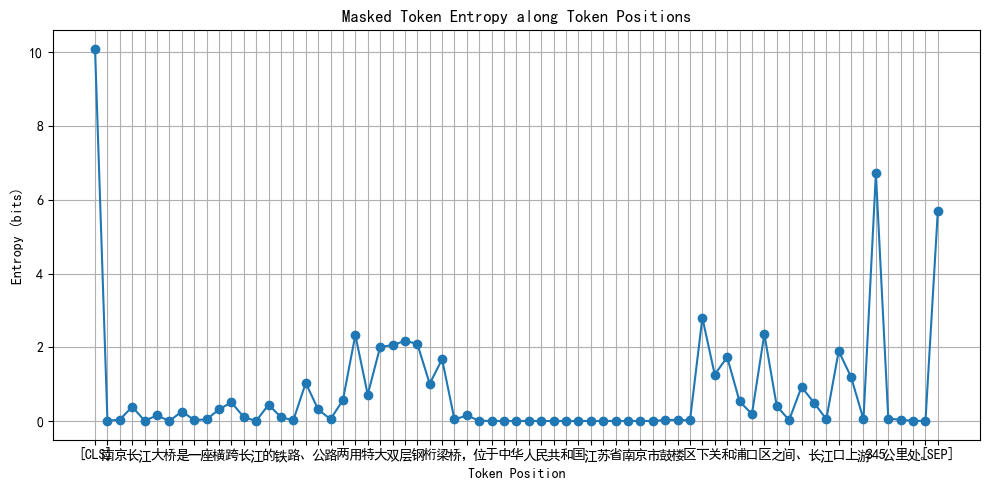

In [25]:
raw_text = "南京长江大桥是一座横跨长江的铁路、公路两用特大双层钢桁梁桥，位于中华人民共和国江苏省南京市鼓楼区下关和浦口区之间、长江口上游345公里处。"
# Compute per-token entropy (using a sliding masking approach)
token_ids, entropies = compute_entropy_chinese_bert(raw_text, tokenizer, model, add_special_tokens=True)
    
plot_entropy(token_ids, entropies, tokenizer)